In [1]:
#HW 4 Vedant Jain


import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms 
from torchvision.transforms import ToPILImage
import torch.nn.functional as F
import numpy as np
import os
import random
import sys
from PIL import Image

import torchvision.models as models

from sklearn.metrics import roc_curve, auc

In [2]:
torch.cuda.is_available()

True

In [3]:
#%% load in the images

from sklearn.datasets import fetch_lfw_pairs
lfw_train = fetch_lfw_pairs(subset='train',color=True, slice_=(slice(0, 250), slice(0, 250)))
lfw_test = fetch_lfw_pairs(subset='test',color=True, slice_=(slice(0, 250), slice(0, 250))) 

In [4]:
first = lfw_train.pairs[1099,0,:,:,:]
second = lfw_train.pairs[1099,1,:,:,:]
lfw_train.pairs.shape

(2200, 2, 125, 125, 3)

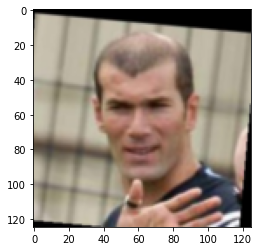

In [5]:
plt.imshow(second.astype('uint8'))
plt.show()

In [6]:
#%% preprocess image
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#input_tensor = preprocess(singleImage.astype(np.uint8))

In [7]:
#%% get labels and individual images
trainLabels = lfw_train.target
testLabels = lfw_test.target

In [8]:
#%% throw into dataloader:
    
class NumbersDataset(Dataset):
    def __init__(self,trainSel):
        self.trainingData = trainSel
        if trainSel == 1:
            self.numEntries = len(trainLabels)
        else:
            self.numEntries = len(testLabels)

    def __len__(self):
        return self.numEntries

    def __getitem__(self, idx):
        if self.trainingData == 1:
            singleImage = lfw_train.pairs[idx,0,:,:,:]
            image1 = preprocess(singleImage.astype(np.uint8))
            secondImage = lfw_train.pairs[idx,1,:,:,:]
            image2 = preprocess(secondImage.astype(np.uint8))
            label = trainLabels[idx]
            return image1, image2, label
        else:
            singleImage = lfw_test.pairs[idx,0,:,:,:]
            image1 = preprocess(singleImage.astype(np.uint8))
            secondImage = lfw_test.pairs[idx,1,:,:,:]
            image2 = preprocess(secondImage.astype(np.uint8))
            label = testLabels[idx]
            return image1, image2, label
            
        

In [9]:
#%% load the dataset
train_set = NumbersDataset(1)
test_set = NumbersDataset(0)
train_loader = DataLoader(train_set, batch_size=50, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)



In [10]:
torch.cuda.is_available()

True

trueLabel = [];
predLabel = [];

for i,data in enumerate(test_loader, 0):
    model.train(mode=False)
    image1s,image2s,labels=data
    image1s = image1s.to(device)
    image2s = image2s.to(device)
    labels = labels.to(device)   
    trueLabel.append(labels.cpu().numpy())
    with torch.no_grad():
        output = model(image1s)
        output2 = model(image2s)
    #getLabels.append(output)
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cos_sim = cos(output, output2)
    predLabel.append(cos_sim.cpu().numpy())
    #print(i)

In [11]:
#%%
def train(train_loader, model, loss_fn, optimizer):
    for i, data in enumerate(train_loader):
        model.train(mode=True)
        image1s,image2s,labels=data
        labels = labels.to(torch.float32)
        image1s = image1s.to(device)
        image2s = image2s.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # Compute prediction error
        output = model(image1s)
        output2 = model(image2s)
    #getLabels.append(output)
        cos = nn.CosineSimilarity(dim=1, eps=1e-8)
        cos_sim = cos(output, output2)
        predVal = cos_sim
        
        # print(predVal)
        # print('True value: ')
        # print(labels)
        
        loss = loss_fn(predVal, labels)
        #print(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()
    print('one Epoch done')
    
    
def test(dataloader, model):
    trueLabel = [];
    predLabel = [];
    model.train(mode=False)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            image1s,image2s,labels=data
            #labels = labels.to(torch.float32)
            image1s = image1s.to(device)
            image2s = image2s.to(device)
            #labels = labels.to(device) 
            output = model(image1s)
            output2 = model(image2s)  
            #trueLabel.append(labels.cpu().numpy())
            cos = nn.CosineSimilarity(dim=1, eps=1e-6)
            cos_sim = cos(output, output2)
            predLabel.append(cos_sim.cpu().numpy())
            trueLabel.append(labels)
    return trueLabel, predLabel



In [12]:
#%% reset Dataset
train_set = NumbersDataset(1)
test_set = NumbersDataset(0)
train_loader = DataLoader(train_set, batch_size=60, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)


In [13]:
#%% define model to use here its VGG
#model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model = models.vgg16(pretrained=True)
model.eval()
new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
model.classifier = new_classifier
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device) 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

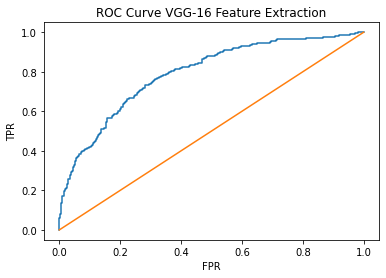

In [14]:
trueLabel, predLabel = test(test_loader, model)
fpr, tpr, thresholds = roc_curve(trueLabel, predLabel)
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC Curve VGG-16 Feature Extraction')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [15]:
aucVal = auc(fpr, tpr)
aucVal

0.791432

In [16]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) #loss earlier was 1e-4

epochs = 10

#%%

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
one Epoch done
Epoch 2
-------------------------------
one Epoch done
Epoch 3
-------------------------------
one Epoch done
Epoch 4
-------------------------------
one Epoch done
Epoch 5
-------------------------------
one Epoch done
Epoch 6
-------------------------------
one Epoch done
Epoch 7
-------------------------------
one Epoch done
Epoch 8
-------------------------------
one Epoch done
Epoch 9
-------------------------------
one Epoch done
Epoch 10
-------------------------------
one Epoch done
Done!


In [17]:
trueLabel, predLabel = test(test_loader, model)

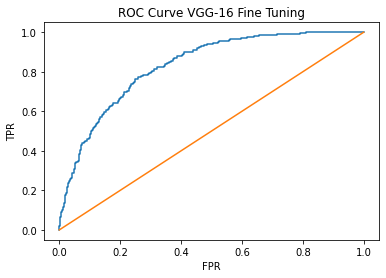

In [18]:
#roc curve graph
fpr, tpr, thresholds = roc_curve(trueLabel, predLabel)
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC Curve VGG-16 Fine Tuning')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [19]:
aucVal = auc(fpr, tpr)
aucVal

0.83124

In [20]:

#%% reset Dataset
train_set = NumbersDataset(1)
test_set = NumbersDataset(0)
train_loader = DataLoader(train_set, batch_size=40, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)


In [27]:
#%% define model to use
#model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
#model = models.vgg16(pretrained=True)
model2 = models.alexnet(pretrained=True)
model2.eval()
new_classifier = nn.Sequential(*list(model2.classifier.children())[:-1])
model2.classifier = new_classifier
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2.to(device) 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

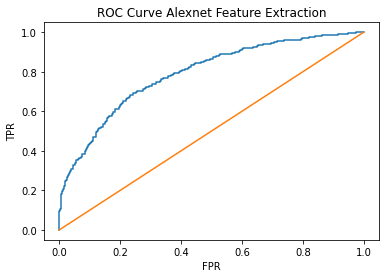

In [22]:
trueLabel, predLabel = test(test_loader, model2)
#roc curve graph
fpr, tpr, thresholds = roc_curve(trueLabel, predLabel)
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC Curve Alexnet Feature Extraction')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [23]:
aucVal = auc(fpr, tpr)
aucVal

0.7899160000000001

In [28]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4) #loss earlier was 1e-4

epochs = 2

#%%

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model2, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
one Epoch done
Epoch 2
-------------------------------
one Epoch done
Done!


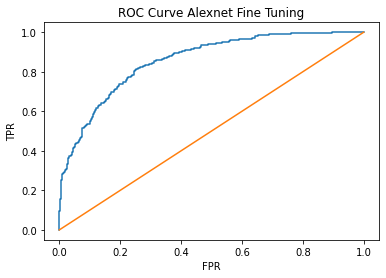

In [29]:
trueLabel, predLabel = test(test_loader, model2)
#roc curve graph
fpr, tpr, thresholds = roc_curve(trueLabel, predLabel)
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC Curve Alexnet Fine Tuning')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()


In [26]:
aucVal = auc(fpr, tpr)
aucVal

0.8529159999999999